In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [2]:
# create datasets
def generate_in_distribution_data(n, mu, sigma, pi_in):
    n_1 = int(n*pi_in)
    n_0 = int(n*(1-pi_in))
    mu_1 = mu
    mu_0 = -mu_1
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, sigma, pi_out, delta):
    n_1 = int(n*pi_out)
    n_0 = int(n*(1-pi_out))
    mu_1 = mu + delta
    mu_0 = -mu + delta
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

In [17]:
def compute_decision_rule(X_in, Y_in, X_out, Y_out, alpha):

    X_in_0 = X_in[Y_in == 0]
    X_in_0_bar = np.mean(X_in_0)

    X_in_1 = X_in[Y_in == 1]
    X_in_1_bar = np.mean(X_in_1)

    X_out_0 = X_out[Y_out == 0]
    X_out_0_bar = np.mean(X_out_0)

    X_out_1 = X_out[Y_out == 1]
    X_out_1_bar = np.mean(X_out_1)

    # estimate threshold
    c = (1-alpha)*(X_in_1_bar + X_in_0_bar)/2 + (alpha)*(X_out_1_bar + X_out_0_bar)/2
    
    return c

def compute_empirical_risk(X, Y, c):
    Y_pred = (X > c).astype('int')
    risk = 1 - np.mean(Y_pred == Y)
    return risk

def run_simulation(
    n = 4,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    delta = 0.8,
    alpha_range=np.arange(0, 1.2, 0.2),
    m_sizes = np.arange(0, 40, 2),
    reps = 1000
):
    X_test, y_test = generate_in_distribution_data(n_test, mu, sigma, pi_in)

    df = pd.DataFrame()
    
    i = 0
    for m in m_sizes:
        for r, rep in enumerate(range(reps)):
            df.at[i, "m"] = m
            df.at[i, "r"] = r
            X_in, Y_in = generate_in_distribution_data(n, mu, sigma, pi_in)
            
            for alpha in alpha_range:
                X_out, Y_out = generate_out_distribution_data(m, mu, sigma, pi_out, delta)
                c = compute_decision_rule(X_in, Y_in, X_out, Y_out, alpha)
                df.at[i, str(alpha)] = 1-compute_empirical_risk(X_test, y_test, c)
            i+=1
    
    dfm = df.melt(['m', 'r'], var_name='Alpha', value_name='Risk')
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
    ax = sns.lineplot(data=dfm, x="m", y="Risk", hue="Alpha", ax=ax, markers=True, ci=95, lw=2)
    ax.set_ylabel("Expected Accuracy")
    ax.set_xlabel(r"$m, n = {}$".format(n))
    # ax.set_xlim([0, 100])
    return df

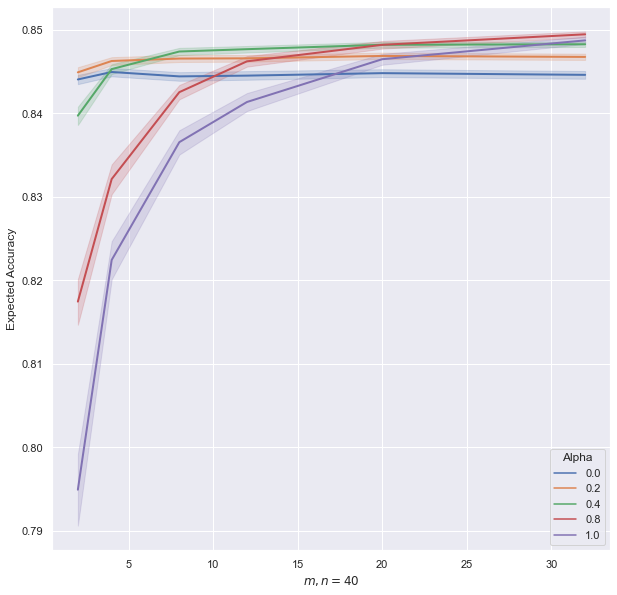

In [18]:
df = run_simulation(
    n = 40,
    n_test = 500,
    mu = 1,
    sigma = 1,
    pi_in = 0.5,
    pi_out = 0.5,
    delta = 0.2,
    alpha_range=[0.0, 0.2, 0.4, 0.8, 1.0],
    m_sizes = [2, 4, 8, 12, 20, 32],
    reps = 1000
)